In [ ]:
import torch
from torchvision import models, datasets
from PIL import Image
from matplotlib import pyplot as plt

In [ ]:
!pip install roboflow
from roboflow import Roboflow
%cd /content
rf = Roboflow(api_key="XBNWFcZ0NkJBGlhEhiIz")
project = rf.workspace("private-sets").project("ocr-tahwd")
dataset = project.version(2).download("folder")

In [ ]:
!cp /content/drive/MyDrive/OCR_418.zip /content
!unzip /content/OCR_418.zip

In [ ]:
!cp /content/drive/MyDrive/Results/OCR/test_ocr_best.pth /content
#!cp /content/drive/MyDrive/Results/OCR/test_ocr_last.pth /content
#!cp /content/drive/MyDrive/Projects/samples/characters/Rorigin.png /content
#!cp /content/drive/MyDrive/Projects/samples/characters/Rwhite.png /content

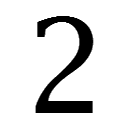

In [ ]:
path = '/content/OCR/val/2/img003-00573.png'
img = Image.open(path)
img

In [ ]:
from torchvision import transforms
transform = transforms.Compose([    # variable transform
    transforms.Resize(256),      # resize 256,256
    transforms.CenterCrop(224),    # Crop the image to 224×224 pixels about the center
    transforms.ToTensor(),      # Convert the image to PyTorch Tensor data type
    transforms.Normalize(       # Normalize
    mean=[0.485, 0.456, 0.406],   # Mean and std of image as also used when training the network
    std=[0.229, 0.224, 0.225])])

In [ ]:
train_dataset = datasets.ImageFolder(root='/content/OCR/train', transform=transform)
val_dataset = datasets.ImageFolder(root='/content/OCR/val', transform=transform)
#test_dataset = datasets.ImageFolder(root='/content/OCR-2/test', transform=transform)
#train_dataset, val_dataset, test_dataset

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=8)
#test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=True, num_workers=8)

train_num, val_num = len(train_loader.dataset), len(val_loader.dataset)
train_num, val_num
#for _, labels in train_loader:
    #print(labels)  # labels: tensor([0, 3, 3, 3]) tensor([2, 3, 4, 1]) tensor([4, 1, 1, 2]) tensor([1, 1, 4, 2]) tensor([4, 0])

(11318, 1894)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
resnet101 = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V2)

resnet101 = torch.nn.DataParallel(resnet101)
resnet101 = resnet101.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet101.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:01<00:00, 94.9MB/s]


In [ ]:
device

device(type='cuda')

In [ ]:
#resnet101.eval()
resnet101.eval().cuda()

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [ ]:
train_epoch = 700
lowest_loss = 0

best_path = '/content/test_ocr_best.pth'
last_path = '/content/test_ocr_last.pth'

for epoch in range(train_epoch):

    #resnet101.train()
    resnet101.train().cuda()
    print(f'Epoch {epoch+1}/{train_epoch}', end=' ')

    training_loss = 0
    correct_train = 0

    for inputs, labels in train_loader:
        # Move input and label tensors to the device
        inputs, labels = inputs.to(device), labels.to(device)
        # Zero out the optimizer
        optimizer.zero_grad()
        # Forward pass
        outputs = resnet101(inputs)
        loss = criterion(outputs, labels)
        # Backward pass
        loss.backward()
        optimizer.step()

        _, predicted_outputs = torch.max(outputs.data, 1)
        correct_train += (predicted_outputs == labels).float().sum().item()
        training_loss += (loss.data.item() * inputs.shape[0])

    train_loss_per_epoch = training_loss
    train_accuracy = correct_train / train_num

    val_loss = 0
    correct_val = 0
    resnet101.eval().cuda()

    with torch.no_grad():
        for inputs, labels in val_loader:
            val_inputs, val_labels = inputs.to(device), labels.to(device)

            val_pred = resnet101(val_inputs)
            val_temp_loss = criterion(val_pred, val_labels)
            _, val_pred_outputs = torch.max(val_pred.data, 1)
            correct_val += (val_pred_outputs == val_labels).float().sum().item()
            val_loss += (val_temp_loss.data.item() * val_inputs.shape[0])

        val_loss_per_epoch = val_loss
        val_accuracy = correct_val / val_num

    # Print the loss for every epoch
    print(f'Train Loss: {train_loss_per_epoch:.6f}, Train Accuracy: {train_accuracy:.3f}, Val Loss: {val_loss_per_epoch:.6f}, Val Accuacy: {val_accuracy:.3f}')

    if epoch == 0:
        torch.save(resnet101, best_path)
        lowest_loss = train_loss_per_epoch
    else:
        if train_loss_per_epoch < lowest_loss:
            torch.save(resnet101, best_path)
            lowest_loss = train_loss_per_epoch
            better_epoch = epoch+1
            print('Better epoch: ', better_epoch)
    torch.save(resnet101, last_path)

#print(f'Finished Training, Loss: {loss.item():.4f}')

#model_save_path = '/content/test_ocr.pth'
#torch.save(resnet101, model_save_path)
print(f'Best Model saved to {best_path}, epoch: {better_epoch}, Loss: {lowest_loss:.6f}')

Epoch 1/700 Train Loss: 8083.873617, Train Accuracy: 0.863, Val Loss: 419.137672, Val Accuacy: 0.940
Epoch 2/700 Train Loss: 426.966118, Train Accuracy: 0.988, Val Loss: 411.584698, Val Accuacy: 0.945
Better epoch:  2
Epoch 3/700 Train Loss: 337.778417, Train Accuracy: 0.990, Val Loss: 589.183095, Val Accuacy: 0.935
Better epoch:  3
Epoch 4/700 Train Loss: 400.571176, Train Accuracy: 0.989, Val Loss: 476.041543, Val Accuacy: 0.949
Epoch 5/700 Train Loss: 355.571415, Train Accuracy: 0.989, Val Loss: 519.641396, Val Accuacy: 0.946
Epoch 6/700 Train Loss: 232.044276, Train Accuracy: 0.992, Val Loss: 327.113622, Val Accuacy: 0.957
Better epoch:  6
Epoch 7/700 Train Loss: 195.609140, Train Accuracy: 0.993, Val Loss: 273.201662, Val Accuacy: 0.959
Better epoch:  7
Epoch 8/700 Train Loss: 189.254168, Train Accuracy: 0.993, Val Loss: 267.124004, Val Accuacy: 0.958
Better epoch:  8
Epoch 9/700 Train Loss: 200.267411, Train Accuracy: 0.992, Val Loss: 314.984667, Val Accuacy: 0.958
Epoch 10/700 T

KeyboardInterrupt: ignored

In [ ]:
!cp /content/ocr_april.pth /content/drive/MyDrive

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

ocr = torch.load('/content/ocr_april.pth', map_location=device)
ocr = ocr.module.to(device)
ocr.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

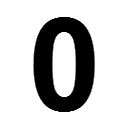

In [ ]:
#labels = ['0','1','2','3','4']
labels = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
img = Image.open('/content/OCR/val/0/img001-00158.png').convert('RGB')

img

In [ ]:
img_t = transform(img)
batch_t = torch.unsqueeze(img_t, 0).to(device)
out = ocr(batch_t)

_, indices = torch.sort(out, descending=True)
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100

for idx in indices[0][:4]:
    print(f'{labels[idx]}: {percentage[idx].item():.2f}%')
#[(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]

0: 100.00%
6: 0.00%
O: 0.00%
Q: 0.00%


In [ ]:
!cp /content/test_ocr_best.pth /content/drive/MyDrive/Results/OCR
!cp /content/test_ocr_last.pth /content/drive/MyDrive/Results/OCR

Others

In [ ]:
img_transform = transform(img)
batch_transform = torch.unsqueeze(img_transform, 0)
img_transform.shape, batch_transform

(torch.Size([3, 224, 224]), torch.Size([1, 3, 224, 224]))

In [ ]:
out = resnet101(batch_transform)
out.shape

torch.Size([1, 1000])

In [ ]:
# reference: https://github.com/meijieru/crnn.pytorch https://github.com/quangnhat185/Plate_detect_and_recognize
#       https://github.com/rohan-paul/Machine-Learning-and-Deep-Learning-Tutorial-Notebooks ResNet56 From Scratch https://www.youtube.com/watch?v=P8U1VL93jzA